# Imports

In [1]:
import multiprocessing as mp

from typing import Iterator, Tuple
import numba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sir import random_sir

# Default Inputs

In [27]:
DATE = "2020-08-24"
FORWARD = True
DAYS = 60
N = 100
FIPS = 17031
GAMMA = 1/7

In [28]:
start = pd.to_datetime(DATE)

In [29]:
shift = pd.Timedelta(pd.offsets.Day(DAYS))

In [30]:
stop = start + shift if FORWARD else start - shift

In [31]:
if stop < start and not FORWARD:
    stop, start = start, stop

# Injected inputs

In [32]:
# Parameters
FIPS = 36061

# Constants

In [33]:
TODAY = pd.Timestamp.today().date()

In [34]:
INPUT_FILE_NAME = f"{TODAY}_{FIPS}_betas.csv"
OUTPUT_FILE_NAME = f"{TODAY}_{FIPS}_random-sir-model-output.csv"

# Read in beta values

In [35]:
beta_df = pd.read_csv(INPUT_FILE_NAME).set_index("beta_day")

# Read in USA FACTS data

In [36]:
case_df = pd.read_csv(
    "https://usafactsstatic.blob.core.windows.net/"
    "public/data/covid-19/covid_confirmed_usafacts.csv",
)

case_df = case_df[case_df["countyFIPS"] == FIPS].melt(
    # Melt dataframe (wide to long format)
    id_vars=["countyFIPS", "County Name", "State", "StateFIPS"],
    value_name="confirmed",
    var_name="date",
).astype({"date": "datetime64"})

In [37]:
# Create a day variable from the date variable
case_df = case_df.assign(
    days=(case_df["date"] - case_df["date"].min()).dt.days
)

# Trim up to but not including day 30
case_df = case_df[case_df["days"].ge(30)]

# Reverse order (highest to lowest day)
case_df = case_df.sort_values("days", ascending=False)

# Replace incorrect values with missing values
while case_df["confirmed"].pct_change().gt(0).any():
    case_df.loc[
        case_df["confirmed"].pct_change().gt(0),
        "confirmed",
    ] = np.nan

# Replace missing values with previous values
case_df.assign(
    confirmed=case_df["confirmed"].ffill()
)

# Restore the original order (lowest to highest day)
case_df = case_df.sort_values(["countyFIPS", "days"])

case_df = case_df.assign(
    # Calculate new cases from confirmed cases
    new_cases=case_df["confirmed"]
    .diff()
    .fillna(0)
)

# Read in county population data

In [38]:
cens_df = pd.read_csv(
    "https://www2.census.gov/programs-surveys/popest/datasets/"
    "2010-2019/counties/totals/co-est2019-alldata.csv",
    usecols=[
        "STATE",
        "COUNTY",
        "STNAME",
        "CTYNAME",
        "POPESTIMATE2019"
    ],
    encoding="latin-1"
)

# Combine state and county fips
cens_df = cens_df.assign(
    county_fips=(
        cens_df["STATE"].astype(str)
        + cens_df["COUNTY"].astype(str).str.zfill(3)
    ).astype(int)
)

In [39]:
# pop_df = pd.read_csv(
#     "https://usafactsstatic.blob.core.windows.net/"
#     "public/data/covid-19/covid_county_population_usafacts.csv",
#     ).set_index("countyFIPS").drop(
#         # Remove unallocated cases (FIPS 0)
#         0
#     ).reset_index()
# pop_df.head()

# Add population to case data

In [40]:
df = case_df.assign(
    population=float(
        cens_df.loc[
        cens_df["county_fips"] == FIPS,
        "POPESTIMATE2019"
        ]
    )
).set_index("date")

# Calculate growth_rate, doubling time, beta, and Rt

$\Huge r = \frac{new\_cases_t - new\_cases_{t-1}}{new\_cases_{t-1}}$

$\Huge T_d=\frac{ln(2)}{ln(r+1)}$

$\Huge \beta=\frac{r+\gamma}{N}$

$\Huge R_t=e^{r\cdot T_c}=\frac{\beta \cdot N}{\gamma}=\frac{r + \gamma}{\gamma}$

$\Huge T_c=\frac{ln(\frac{\beta \cdot N}{\gamma})}{r}=\frac{ln(\frac{r + \gamma}{\gamma})}{r}$

In [41]:
# %% Growth rate
df = df.assign(
    susceptible=df["population"] - (df["confirmed"] * 10),
    gr=df["new_cases"].pct_change() / df["days"].diff(),
)

# Remove infinite and missing growth rates 
df["gr"] = df["gr"].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["gr"])

# Doubling time, beta, and Rt
df = df.assign(
    tc=np.log((df["gr"] + GAMMA) / GAMMA) / df["gr"],
    dt=np.log(2) / np.log(df["gr"] + 1),
    beta=(df["gr"] + GAMMA) / df["susceptible"],
)

# If growth rate is zero, Rt = e^0 = 1, regardless of the value of Tc
df.loc[df["gr"]==0, "tc"] = 0

df = df.assign(
    # Calculate 7-day moving average of growth rate
    smooth_gr=df["gr"].rolling(
        window=7,
        min_periods=1
    ).mean(),
    # Calculate 7-day moving average of mean generation interval
    smooth_tc=df["tc"].rolling(
        window=7,
        min_periods=1
    ).mean(),
)

df["e^r"] = np.exp(df["gr"])
df["e^smooth_r"] = np.exp(df["smooth_gr"])
df["r+gamma"] = df["gr"]+GAMMA

df = df.assign(
    smooth_dt=np.log(2) / np.log(df["smooth_gr"] + 1),
    smooth_beta=(df["smooth_gr"] + GAMMA) / df["susceptible"],
    new_rt=np.exp(df["gr"]*df["tc"]),
    old_rt=(df["gr"] + GAMMA) / GAMMA,
    new_smooth_rt=np.exp(df["smooth_gr"]*df["smooth_tc"]),
    old_smooth_rt=(df["smooth_gr"] + GAMMA) / GAMMA,
)

/Users/martinskarzynski/miniconda/envs/py/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/martinskarzynski/miniconda/envs/py/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Select betas (if not provided)

In [42]:
# All betas
# betas = np.random.choice(df["beta"], size=100)
# County-specific betas
# betas = np.random.choice(county_df["beta"], size=1000)
# County-specific and interval-specific betas
# if betas is None:
#     start_beta = START_DATE - pd.DateOffset(days=14) 
#     end_beta = START_DATE + pd.DateOffset(days=7) 
#     betas = np.random.choice(
#         df.loc[start_beta:end_beta, "smooth_beta"], size=100
#     )
#     # Remove betas that equal zero, inf, or nan
#     not_zero = betas != 0
#     not_miss = ~np.isnan(betas)
#     not_infi = ~np.isinf(betas)
#     betas = betas[not_zero & not_miss & not_infi]

In [43]:
betas = np.random.choice(beta_df["beta"], size=(N, DAYS))

$\Huge p = \frac{\beta \cdot infected}{susceptible}$

In [44]:
def parallel_sir(
    susceptible: int,
    infected: int,
    recovered: int,
    beta: float = None,
    betas: Iterator[float] = None,
    gamma: float = 1 / 7,
    case_adjustment_factor: float = 10,
    start: int = 0,
    stop: int = 90
) -> Iterator[Tuple[
    int,
    int,
    int,
    int,
]]:
    """
    Calculate the number of susceptible people and incidence and prevalence
    of infection and recovery in a population based on initial values.

    Core SIR model function that forecasts new
    - susceptible (S),
    - infected (I), and
    - recovered (R) values

    Arguments:
        susceptible: Initial number of susceptible people.
        infected: Initial number of total confirmed infections.
        recovered: Initial number of people who have recovered.
        beta: The effective contact rate during social distancing.
            BETA = (GROWTH_RATE + GAMMA) / SUSCEPTIBLE
        betas: A generator that provides beta values.
        gamma: The inverse of the recovery length, e.g.
            RECOVERY_TIME = 7
            GAMMA = 1 / RECOVERY_TIME
        case_adjustment_factor: A multiplier to estimate the true case count.
            Under-reporting of cases is common because many are asymptomatic.
            The case adjustment factor compensates for under-reporting.
        start: The day for which initial values are provided, e.g. day 0.
        stop: The total number of days to forecast (daily projections).

    Yields:
        Collected values across each day from start to end.
        1. day
        2. susceptible
        3. total infected (infected prevalence)
        4. total recovered (recovered prevalence)
    """
    # Iterate over days and yield model outputs
    for day, b in zip(range(start, stop + 1), betas):
        yield (
            day,
            b,
            susceptible,
            infected,
            recovered,
        )
        # Calculate probability of becoming infected
        prob = b * infected / susceptible
        # If probability is nan, inf, greater than one, or less than zero,
        if np.isinf(prob) or np.isnan(prob) or prob > 1 or prob < 0:
            # set probability to zero
            prob = 0
        # New confirmed infections (new positive tests)
        infected_incidence = np.random.binomial(
            susceptible,
            prob,
            susceptible
        ).sum()
        # Number of infected who have just recovered
        recovered_incidence = int(round(gamma * infected, 0))
        # Number of people who are susceptible as of this time point
        susceptible_new = max(
            susceptible - case_adjustment_factor * infected_incidence,
            0
        )
        # Total number of people who are infected as of this time point
        infected_prevalence = max(
            infected_incidence + infected - recovered_incidence,
            0
        )
        # Total number of people who have recovered as of this time point
        recovered_prevalence = max(
            recovered_incidence + recovered
            + infected_incidence * max(1., case_adjustment_factor - 1),
            0
        )
        # Overwrite initial values with current values
        susceptible, infected, recovered = (
            susceptible_new, infected_prevalence, recovered_prevalence
        )

In [45]:
# Run the simulation for all sampled betas
arr = np.concatenate([
    tuple(
        parallel_sir(
            susceptible=int(round(df.loc[start.date(), "population"], 0)),
            infected=int(round(df.loc[start.date(), "confirmed"], 0)),
            recovered=0,
            betas=beta_array,
            gamma=GAMMA,
            start=0,
            stop=100
            )
        ) for beta_array in betas
    ],
    axis=1
)

In [46]:
# Create a separate array for s, i, and r columns
s = arr[:, 2::5]
i = arr[:, 3::5]
r = arr[:, 4::5]

In [47]:
# Remove columns that do not show an outbreak
s_trim = s[:, (s < np.max(s) * .9).sum(axis=0) / len(s) >= .1]
i_trim = i[:, (i > np.max(i) * .01).sum(axis=0) / len(i) >= .5]
r_trim = r[:, (r > np.max(r) * .1).sum(axis=0) / len(r) >= .5]

In [48]:
# confirmed
c_trim = s_trim[0] - s_trim

# Plot all simulations as separate lines

<ipython-input-51-ce524c499ae1>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().ticklabel_format(style="plain")


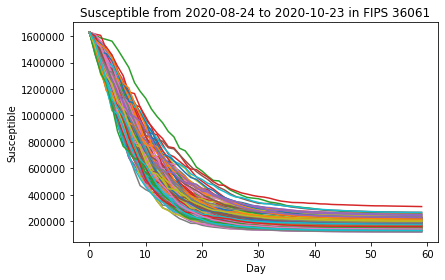

In [51]:
plt.xlabel('Day')
plt.ylabel('Susceptible')
plt.title(f'Susceptible from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
plt.axes().ticklabel_format(style="plain")
plt.plot(s_trim)
plt.savefig(f"{TODAY}_{FIPS}_susceptible.png");

<ipython-input-53-1e0683ce6410>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().ticklabel_format(style="plain")


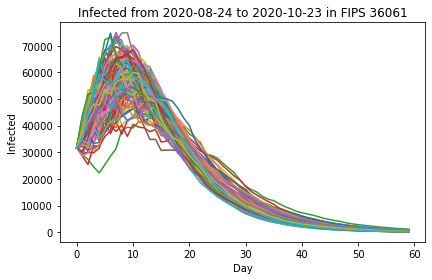

In [53]:
plt.xlabel('Day')
plt.ylabel('Infected')
plt.title(f'Infected from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
plt.axes().ticklabel_format(style="plain")
plt.plot(i_trim)
plt.savefig(f"{TODAY}_{FIPS}_infected.png");

<ipython-input-54-6ef31e4ca794>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().ticklabel_format(style="plain")


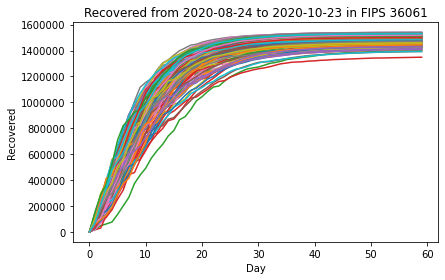

In [54]:
plt.xlabel('Day')
plt.ylabel('Recovered')
plt.title(f'Recovered from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
plt.axes().ticklabel_format(style="plain")
plt.plot(r_trim)
plt.savefig(f"{TODAY}_{FIPS}_recovered.png");

<ipython-input-55-84cd2b06f6c4>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().ticklabel_format(style="plain")


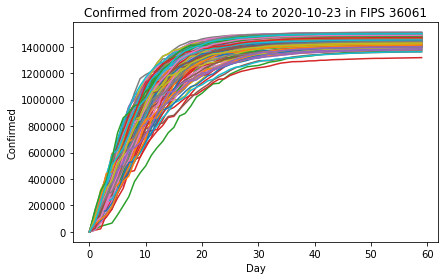

In [55]:
plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.title(f'Confirmed from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
plt.axes().ticklabel_format(style="plain")
plt.plot(c_trim)
plt.savefig(f"{TODAY}_{FIPS}_confirmed.png");

# Plot the median of all simulations with 95% confidence intervals

In [56]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

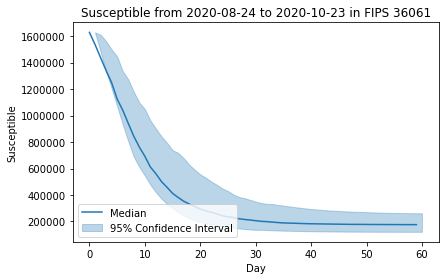

In [60]:
sdf = pd.DataFrame(s)
ax = (sdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[0], label='Median')

upper = sdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = sdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[0], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel('Susceptible')
plt.title(f'Susceptible from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
ax.ticklabel_format(style="plain")
ax.legend(loc=3)
plt.savefig(f"{TODAY}_{FIPS}_susceptible_CI95.png");

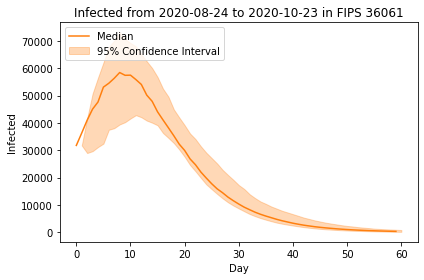

In [61]:
idf = pd.DataFrame(i)
ax = (idf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[1], label='Median')

upper = idf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = idf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[1], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel('Infected')
plt.title(f'Infected from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
ax.ticklabel_format(style="plain")
ax.legend(loc="upper left")
plt.savefig(f"{TODAY}_{FIPS}_infected_CI95.png");

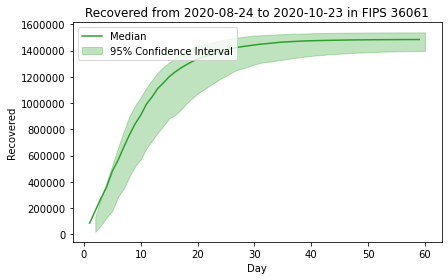

In [62]:
rdf = pd.DataFrame(r)
ax = (rdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[2], label='Median')

upper = rdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = rdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[2], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel('Recovered')
plt.title(f'Recovered from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
ax.ticklabel_format(style="plain")
ax.legend(loc="upper left")
plt.savefig(f"{TODAY}_{FIPS}_recovered_CI95.png");

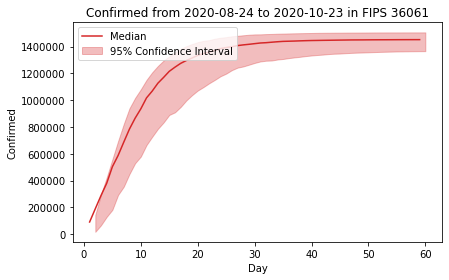

In [64]:
cdf = pd.DataFrame(c_trim)
ax = (cdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[3], label='Median')

upper = cdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = cdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[3], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel('Confirmed')
plt.title(f'Confirmed from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
ax.ticklabel_format(style="plain")
ax.legend(loc="upper left")
plt.savefig(f"{TODAY}_{FIPS}_confirmed_CI95.png");

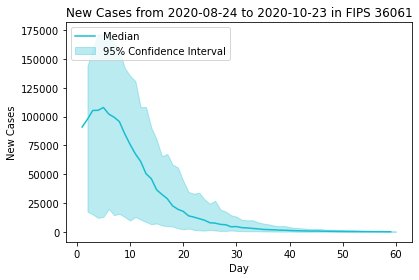

In [66]:
ndf = cdf.diff()
ax = (ndf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[9], label='Median')

upper = ndf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = ndf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[9], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel('New Cases')
plt.title(f'New Cases from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
ax.ticklabel_format(style="plain")
ax.legend(loc="upper left")
plt.savefig(f"{TODAY}_{FIPS}_total-population-minus-current-susceptible_CI95.png");

<ipython-input-68-41c59d28d441>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().ticklabel_format(style="plain")


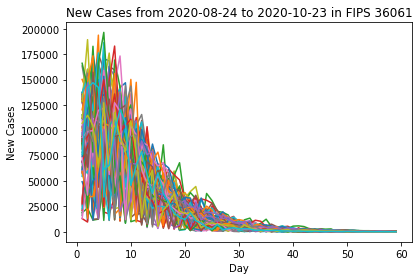

In [68]:
ndf.plot(legend=False)
plt.xlabel('Day')
plt.ylabel('New Cases')
plt.title(f'New Cases from {start.date()} to {stop.date()} in FIPS {FIPS}')
plt.tight_layout()
plt.axes().ticklabel_format(style="plain")
ax.legend(loc="upper left")
plt.savefig(f"{TODAY}_{FIPS}_total-population-minus-current-susceptible.png");

# Plot new cases (ndf) MOST IMPORTANT!!!!

# Growth rate

In [69]:
gdf = ndf.pct_change()

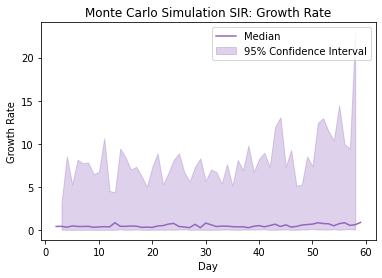

In [70]:
ax = (gdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[4], label='Median')

upper = gdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = gdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[4], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel('Growth Rate')
ax.legend()
plt.title('Monte Carlo Simulation SIR: Growth Rate')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-gr.png");

In [71]:
smoothed_gdf = gdf.rolling(window=7, min_periods=1).mean()

# Old $R_t$ with unsmoothed growth rate

In [72]:
rdf = (gdf + GAMMA) / GAMMA

In [73]:
rdf.min().min()

-6.000000000000001

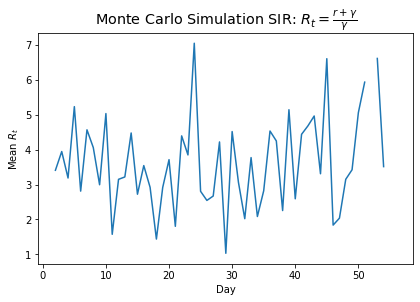

In [74]:
rdf.mean(axis=1).plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'Mean $R_t$')
plt.tight_layout()
plt.title(r'Monte Carlo Simulation SIR: $R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-old-rt_mean.png");

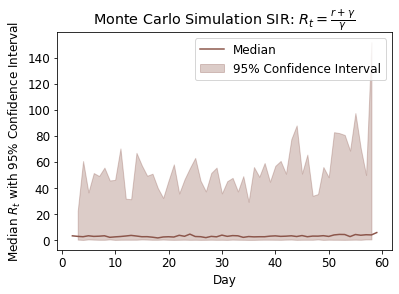

In [75]:
ax = (rdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[5], label='Median')

upper = rdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = rdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[5], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel(r'Median $R_t$ with 95% Confidence Interval')
ax.legend()
plt.title(r'Monte Carlo Simulation SIR: $R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-old-rt_CI95.png");

# Old $R_t$ with smoothed growth rate

In [76]:
rdf = (smoothed_gdf + GAMMA) / GAMMA

In [77]:
rdf.min().min()

-4.933780099954566

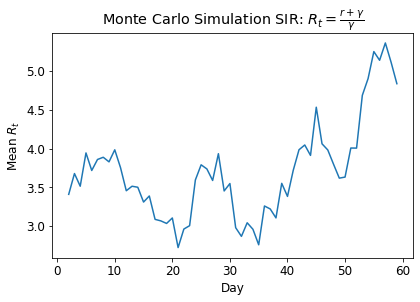

In [78]:
rdf.mean(axis=1).plot()
plt.rcParams.update({'font.size': 12})
plt.xlabel('Day')
plt.ylabel(r'Mean $R_t$')
plt.tight_layout()
plt.title(r'Monte Carlo Simulation SIR: $R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-old-rt_mean.png");

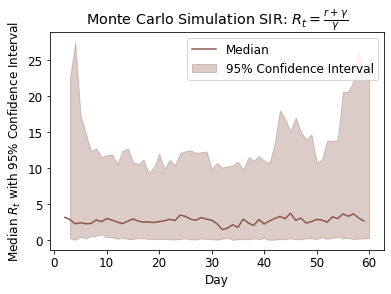

In [79]:
ax = (rdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[5], label='Median')

upper = rdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = rdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[5], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel(r'Median $R_t$ with 95% Confidence Interval')
ax.legend()
plt.title(r'Monte Carlo Simulation SIR: $R_t = \frac{r + \gamma}{\gamma}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-old-rt_CI95.png");

# New $R_t$ with unsmoothed growth rate

In [80]:
tdf = np.log((gdf + GAMMA) / GAMMA) / gdf

<ipython-input-80-831fc4b74086>:1: RuntimeWarning: invalid value encountered in log
  tdf = np.log((gdf + GAMMA) / GAMMA) / gdf


In [81]:
rdf = np.exp(gdf*tdf)

In [82]:
rdf.min().min()

0.0005010020040083221

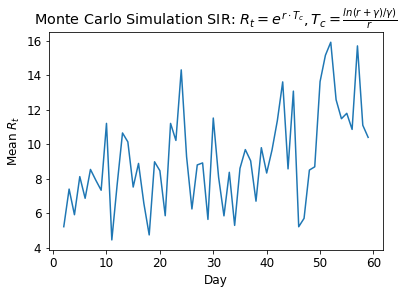

In [83]:
rdf.mean(axis=1).plot()
plt.xlabel('Day')
plt.ylabel(r'Mean $R_t$')
plt.title(r'Monte Carlo Simulation SIR: $R_t = e^{r\cdot T_c}, T_c = \frac{ln(r + \gamma)/\gamma)}{r}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-new-rt_mean.png");

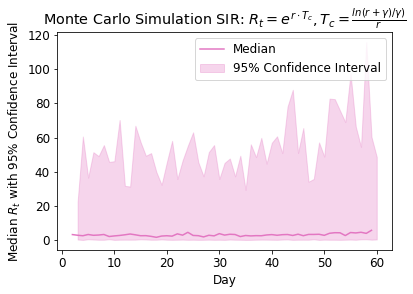

In [84]:
ax = (rdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[6], label='Median')

upper = rdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = rdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[6], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel(r'Median $R_t$ with 95% Confidence Interval')
ax.legend()
plt.title(r'Monte Carlo Simulation SIR: $R_t = e^{r\cdot T_c}, T_c = \frac{ln(r + \gamma)/\gamma)}{r}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-new-rt_CI95.png");

In [85]:
tdf = np.log((gdf + GAMMA) / GAMMA) / gdf

<ipython-input-85-831fc4b74086>:1: RuntimeWarning: invalid value encountered in log
  tdf = np.log((gdf + GAMMA) / GAMMA) / gdf


# New $R_t$ with smoothed growth rate

In [86]:
rdf = np.exp(smoothed_gdf*tdf)

In [87]:
rdf.min().min()

0.0004855099584844254

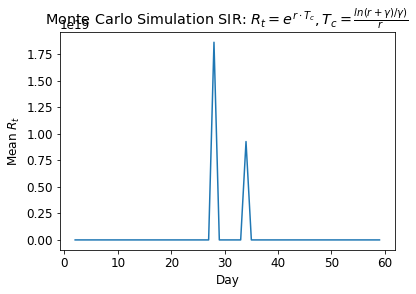

In [88]:
rdf.mean(axis=1).plot()
plt.xlabel('Day')
plt.ylabel(r'Mean $R_t$')
plt.title(r'Monte Carlo Simulation SIR: $R_t = e^{r\cdot T_c}, T_c = \frac{ln(r + \gamma)/\gamma)}{r}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-new-rt_mean.png");

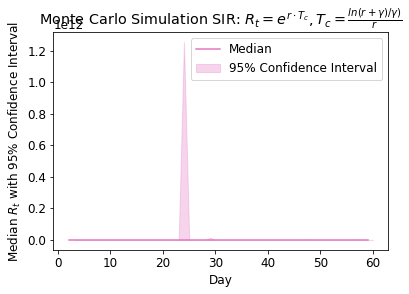

In [89]:
ax = (rdf.apply(lambda x: x[x>0].median(), axis=1)).plot(c=colors[6], label='Median')

upper = rdf.apply(lambda x:x[x>0].quantile(0.975), axis=1)
lower = rdf.apply(lambda x:x[x>0].quantile(0.025), axis=1)

ax.fill_between(np.arange(1, DAYS+1), 
                y1=lower, 
                y2=upper, color=colors[6], alpha=0.3,
                label='95% Confidence Interval')

ax.set_xlabel('Day')
ax.set_ylabel(r'Median $R_t$ with 95% Confidence Interval')
ax.legend()
plt.title(r'Monte Carlo Simulation SIR: $R_t = e^{r\cdot T_c}, T_c = \frac{ln(r + \gamma)/\gamma)}{r}$')
plt.savefig(f"{TODAY}_{FIPS}_monte-carlo-new-rt_CI95.png");

In [90]:
rdf.max().max()

1.0241309568265536e+21

Filling in a backlog of cases (sudden increase)

When we have 
1. growth rate greater than 1 and then 
2. many zeros and then 
3. a large number,
divide large number by number of zeros + 1,
and then compare to average before zeros.
If the result is greater than half of the previous average,
fill in all timepoints with the result.

T0: nonzero cases, growth rate greater than 1, some 7-day rolling average
T1 to Tn-1: Zeros
Tn: nonzero cases, growth rate is infinite
n: len(range(T1, Tn))

result = Tn_cases / n

suddens = 0
dramatics = 0

While ...:
sudden = result > 0.5 * T0_smooth_mean
dramatic = sudden and T0_smooth_mean > 100

suddens += sudden
dramatics += dramatic

If sudden and dramatic,
fill in T1-Tn with result

Count:
suddens: number of times this happens
dramatic: number of times this happens and the T0_smooth_mean > 100

Capture volatility
What is an outlier?
What do we do with outliers?
drop or replace with curve fitted value?
drop or impute
